This notebook serves to update the figures in the paper

In [214]:
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('text', usetex=True)
import matplotlib as mpl
font = {'size'   : 26}
mpl.rc('font', **font)

import numpy as np
from astropy.cosmology import Planck18, z_at_value
cosmo = Planck18
from scipy import integrate
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pickle, os

import h5py
import astropy.units as u

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [215]:
def compute_conf_intervals(pdf, x, lims = [0.0013498980, 0.0227501319, 0.15865525, 
                                      0.500, 0.8413447, 0.97724986, 0.998650102]):
    """
    Compute confidence intervals for a given pdf
    
    Parameters
    ----------
    x (array): x coordinates
    pdf (array): probability density function evaluated at x
    lims (array): confidence intervals to compute

    Returns
    -------
    CI (array): confidence intervals
    
    """
    

    norm = integrate.trapz(pdf, x)
    intcum = integrate.cumtrapz(pdf/norm.reshape(-1,1), x, initial=0.)
    if np.squeeze(pdf).ndim > 1:
        CI = []
        for ic in intcum:
            CIz = []
            for lim in lims:
                CIz.append(x[np.argmin(np.abs(ic-lim))])
            CI.append(CIz)
    else:
        CI = x[[np.max(np.where(intcum < lim)) for lim in lims]]
        
    return intcum, np.vstack(CI)


In [216]:
cosmo = Planck18# Define temporary cosmology for volume calculation
tot_sky = 41253. # Total square degrees in the sky

halo_model = "SMT"

mmin = 3 # Minimum halo mass for HMF
mmax = 15 # Maximum halo mass for HMF

baryon_frac = 0.016 # from Planck18
c = 'orange'

In [217]:
cols = ['t', 'm0', 'm1', 'm2', 'm3', 'm4']
df0 = pd.read_csv('data/AC_117560.txt', names = cols, sep = '\s+')
df1 = pd.read_csv('data/AC_109760.txt', names = cols, sep = '\s+')
df2 = pd.read_csv('data/AC_55410.txt', names = cols, sep = '\s+') 

text_names = [r'$\mathrm{PRIMER-EXCELS-117560}$', r'$\mathrm{PRIMER-EXCELS-109760}$', r'$\mathrm{ZF-UDS-7329}$']
title_names = [r'$\mathrm{117560}$ ', r'$\mathrm{109760}$ ', r'$\mathrm{7329}$ ']

df0 = df0[df0['t']>0.15]
df1 = df1[df1['t']>0.15]
df2 = df2[df2['t']>0.15]
## transfer time into redshift - somewhat slow
z_AC0 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df0['t']])
z_AC1 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df1['t']])
z_AC2 = np.array([z_at_value(cosmo.age, t * u.Gyr) for t in df2['t']])

In [219]:
def plotax(ax, zs, meds, sig1s, sig2s, sig3s = None, xlabel = True, d=0, ylabel = True, c='orange', survey = 'GS-55410 ', ty = 'SED-fitting', filter_size = 0.1, xmin = 3.2, log = False, leg = True, met = '', med_label = False):
    if log:
        meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )
    if med_label:
        ax.plot(zs, np.array(meds)-d, 'k--', linewidth=3, label = 'Median')
    else:
        ax.plot(zs, np.array(meds)-d, 'k--', linewidth=3)
        
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig1s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig1s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.3, label = r'1$\sigma$'+met)
    
    ax.fill_between(zs, gaussian_filter1d(np.vstack(sig2s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig2s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.2, label = r'2$\sigma$'+met)
    if np.any(sig3s):
        ax.fill_between(zs, gaussian_filter1d(np.vstack(sig3s)[:,0], filter_size)-d,\
                          gaussian_filter1d(np.vstack(sig3s)[:,1], filter_size)-d, color = c, rasterized = True,\
                        alpha=0.1, label = r'3$\sigma$'+met)
    
    ax.grid(visible = True,alpha=0.3)
    if ty:
        ax.set(title = f'{survey}{ty}', ylim = (8.0,11.8), xlim = (xmin,13.5))
    else:
        ax.set(ylim = (8,11.8), xlim = (3.2,13))
        
    if ylabel:
        # ax.set(ylabel = r'$\mathrm{Stellar~mass}$ [$\mathrm{log}(M_*/M_{\odot})$]')
        ax.set(ylabel = r'$\mathrm{M_{*,max}}$ [$\mathrm{log}(M_*/M_{\odot})$]')

    if xlabel:
        ax.set(xlabel='z')

    if leg:
        ax.legend(ncol=2, fontsize = 16, loc = 'lower left', columnspacing=0.5)

    return ax

<ipython-input-219-c1a3653c6e3d>:3: RuntimeWarning: divide by zero encountered in log10
  meds, sig1s, sig2s = np.log10( meds ), np.log10( sig1s ), np.log10( sig2s )


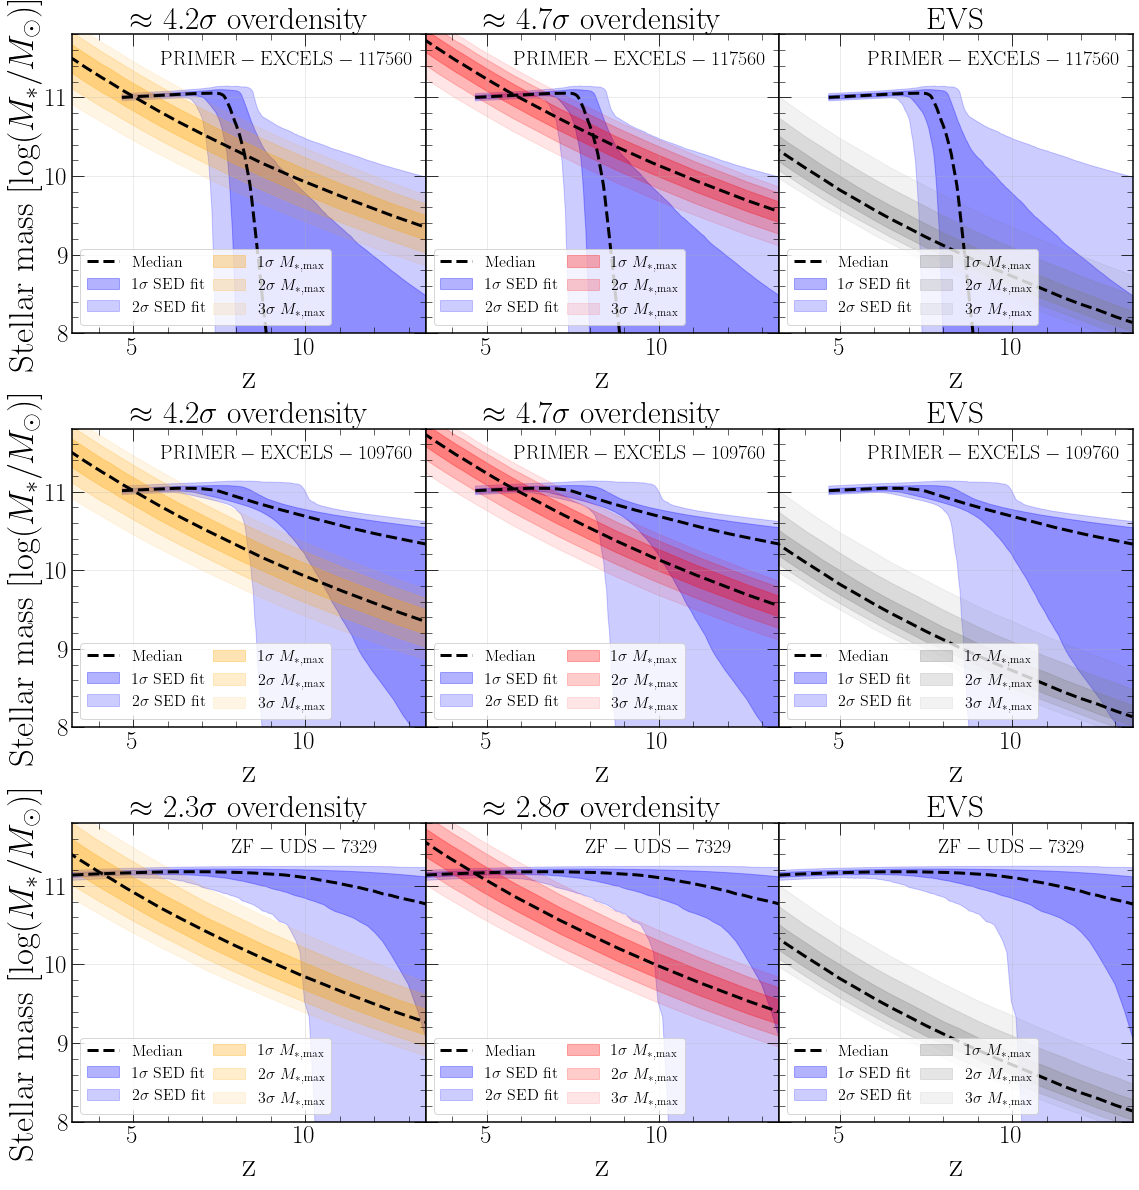

In [220]:
from evstats.evs import _apply_fsky
from evstats.stats import compute_conf_ints


fig, axss = plt.subplots(nrows = 3, ncols = 3, figsize = (19, 20), sharey = True)
axs = axss[0]

cols = ['t', 'm0', 'm1', 'm2', 'm3', 'm4']
plt.subplots_adjust(wspace = 0.0, hspace = 0.32) 
c_SED = 'b'
for idx, df, z_AC in zip([0, 1, 2], [df0, df1, df2], [z_AC0, z_AC1, z_AC2]):
    axs = axss[idx]
    plotax(axs[0], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, log = True, c = c_SED, xmin = np.min(z_AC), survey = title_names[idx], met = ' SED fit', med_label = True)
    plotax(axs[1], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T, ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC), survey = title_names[idx], met = ' SED fit', med_label = True  )
    plotax(axs[2], z_AC, df['m2'], np.vstack([df['m3'], df['m1']]).T, np.vstack([df['m0'], df['m4']]).T,  ylabel = False, log = True, c = c_SED, xmin = np.min(z_AC), survey = title_names[idx], met = ' SED fit', med_label = True  )

cs = ['orange', 'red', 'grey']
c_EVS = 'green'
sigs = [[4.2, 4.7], [4.2, 4.7], [2.3, 2.8]]
sizes = ['small', 'small', 'big']
for j, OD in enumerate(sizes):
    axs = axss[j]
    for i, sig in enumerate([0.0, 0.5]):
        
        with h5py.File(f'../evstats/data/{OD}_OD_fast_{sig}.h5','r') as hf:
            log10m = hf['log10m'][:]
            z = hf['z'][:]
            evs_OD = hf['evs_OD'][:]
            phi_max_conv = hf['phi_max_conv'][:]
            phi_maxs = hf['phi_maxs'][:]
            smfs = hf['smf'][:]

        cdf, CIs = compute_conf_intervals(phi_max_conv, log10m[:-1])
        zs = z
        meds_cdf = CIs[:,3]
        sig1s = np.vstack([CIs[:,2], CIs[:,4]]).T
        sig2s = np.vstack([CIs[:,1], CIs[:,5]]).T
        sig3s = np.vstack([CIs[:,0], CIs[:,6]]).T

        plotax(axs[i], zs, meds_cdf, sig1s, sig2s, sig3s = sig3s, d=0, ylabel = False, survey = fr'$\approx$ ${sigs[j][i]}\sigma$' + r' $\mathrm{overdensity}$ ', ty = ' ', c = cs[i], xmin = np.min(z_AC), met = r' $M_{*,\mathrm{max}}$')
        
    with h5py.File(os.path.expanduser('data/EXCELS.h5'),'r') as hf:
        log10m_EVS = hf['log10m'][:]
        f = hf['f'][:]
        F = hf['F'][:]
        N = hf['N'][:]
        zs_EVS = hf['z'][:]

    whole_sky = (41252.96 * u.deg**2).to(u.arcmin**2)
    survey_area = 160 * u.arcmin**2
    fsky = float(survey_area / whole_sky)
    phi_max0 = _apply_fsky(N, f, F, fsky)
    meds_cdf = []
    sig1s = []
    sig2s = []
    sig3s = []
    for k in range(len(zs_EVS)):

        z0 = zs_EVS[k]
        sbf = 0.1 + 0.02 * (z0 - 4)
        M1 = log10m_EVS+np.log10(baryon_frac)+np.log10(sbf)
        cdf =  np.cumsum(phi_max0[k]*M1)/np.sum(phi_max0[k]*M1)
        meds_cdf.append(M1[np.argmin(abs(cdf-0.5))])
        sig1s.append([M1[np.argmin(abs(cdf-norm.cdf(-1)))], M1[np.argmin(abs(cdf-norm.cdf(1)))]])
        sig2s.append([M1[np.argmin(abs(cdf-norm.cdf(-2)))], M1[np.argmin(abs(cdf-norm.cdf(2)))]])
        sig3s.append([M1[np.argmin(abs(cdf-norm.cdf(-3)))], M1[np.argmin(abs(cdf-norm.cdf(3)))]])
        # CIs = compute_conf_ints(phi_max0[k], M1)
        
        # meds_cdf.append(CIs[3])
        # sig1s.append(np.vstack([CIs[2], CIs[4]]).T)
        # sig2s.append(np.vstack([CIs[1], CIs[5]]).T)
        # sig3s.append(np.vstack([CIs[0], CIs[6]]).T)
    i = i+1
    plotax(axs[i], zs_EVS, meds_cdf, sig1s, sig2s, sig3s = sig3s, d=0, ylabel = False, survey = r'$\mathrm{EVS}$', ty = ' ', c = cs[i], xmin = np.min(z_AC), met = r' $M_{*,\mathrm{max}}$')
    
for i in range(3):
    for j in range(3):
        name = text_names[i]
        x0 = 0.25
        if i == 2:
            x0 = 0.45
        axss[i][j].annotate(name, xy = (x0,0.9), xycoords = 'axes fraction', fontsize = 20)

# fig.suptitle(r'$\mathrm{Most~massive~galaxies~in~different~overdensities}$', y = 0.93)

In [221]:
# Adjust the bottom row (row index 2) downward
for ax in axss[2, :]:  # Iterate over all columns in the bottom row
    pos = ax.get_position()  # Get the original position
    ax.set_position([pos.x0, pos.y0 - 0.03, pos.width, pos.height])  # Shift downward

plt.show()

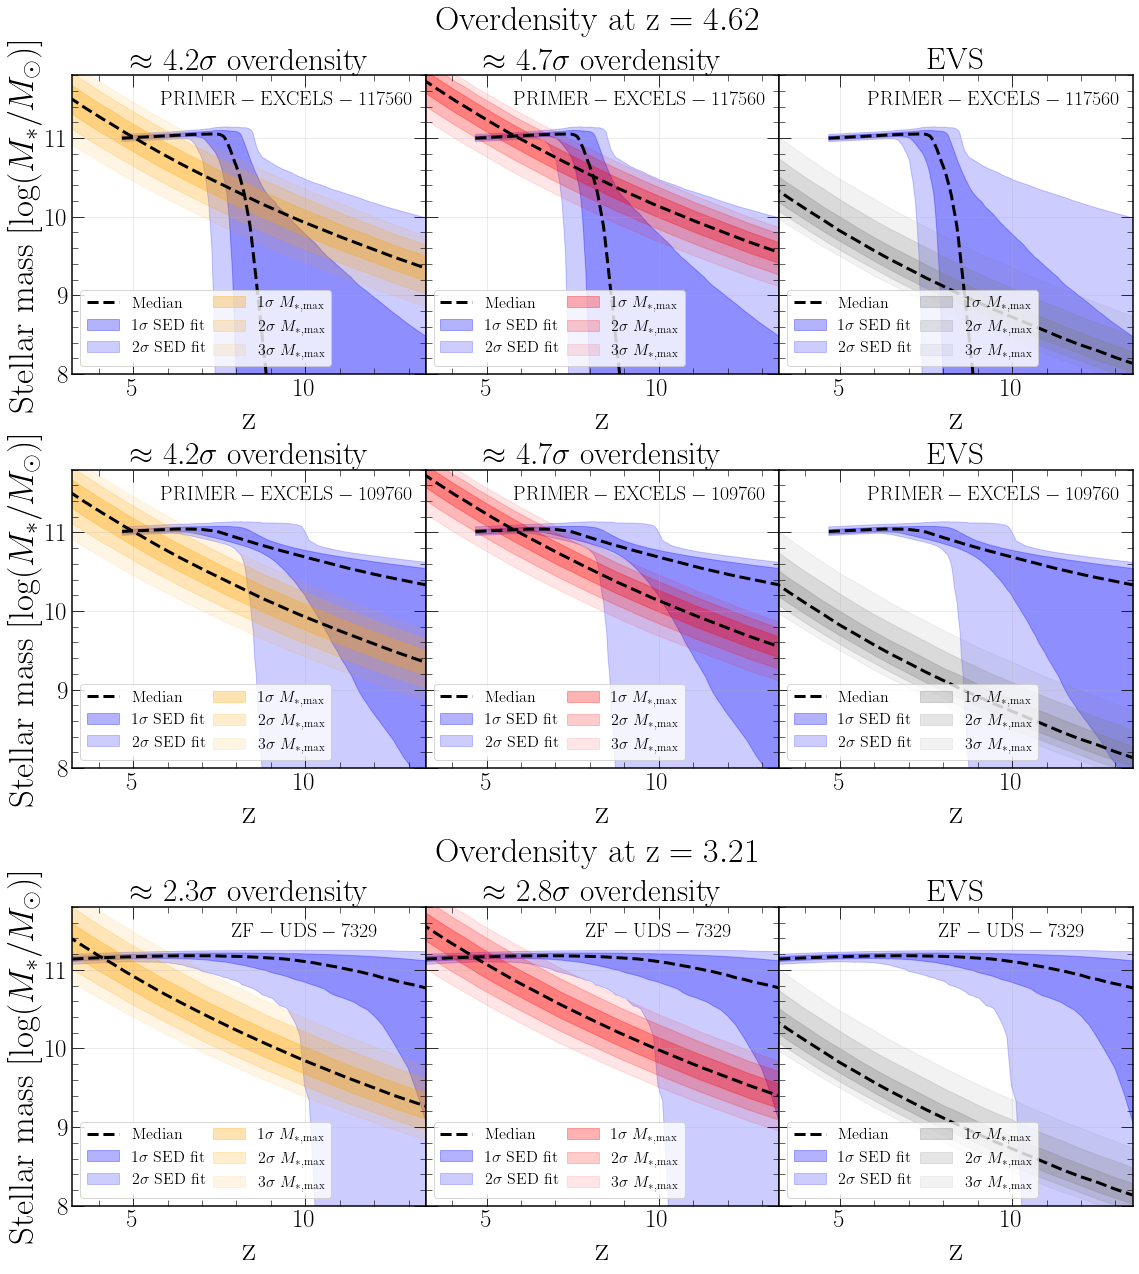

In [222]:
axss[0][1].annotate(r'$\mathrm{Overdensity~at~z = 4.62}$', xy = (0.03,1.15), xycoords = 'axes fraction', fontsize = 34)
axss[2][1].annotate(r'$\mathrm{Overdensity~at~z = 3.21}$', xy = (0.03,1.15), xycoords = 'axes fraction', fontsize = 34)

fig

In [223]:
fig.savefig('paper/combined.png', bbox_inches = 'tight', dpi = 200)

Now let's make the distribution of masses given some number of sampled overdensities

In [182]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.facecolor"] = "white"
plt.rc("text", usetex=True)
plt.rc("font", family="serif",size= 40)
plt.rc("axes", linewidth=1.5)
plt.rc("axes", labelsize=35)
plt.rc("xtick", labelsize=25, direction="in")
plt.rc("ytick", labelsize=25, direction="in")
plt.rc("xtick", top=True)
plt.rc("ytick", right=True)
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.major",size=12, pad=4)
plt.rc("xtick.minor",size=6, pad=4)
plt.rc("ytick.major",size=12)
plt.rc("ytick.minor",size=6)
plt.rc("legend", fontsize=23)

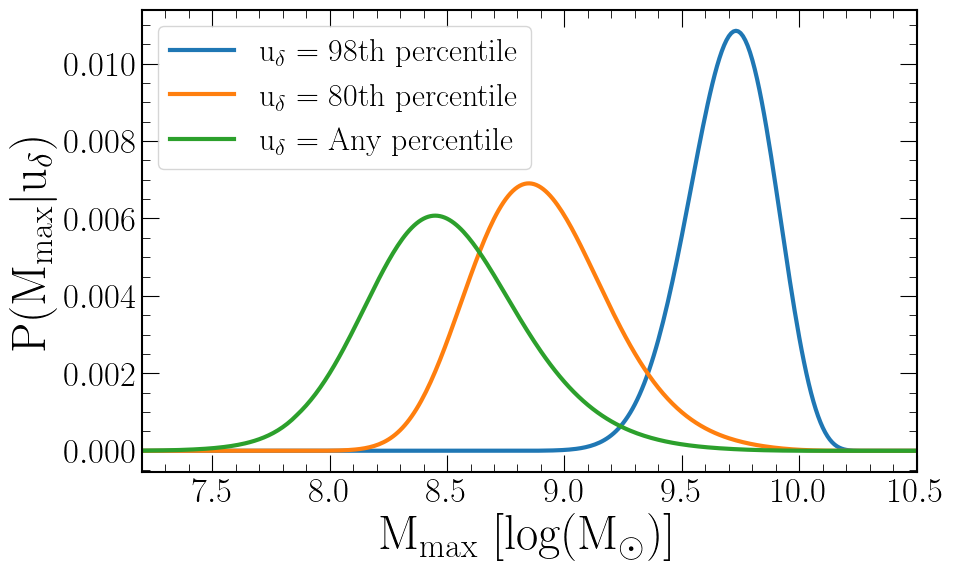

In [122]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['98th', '80th', 'Any']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{u}_{\delta}$'+' = '+sigl + ' percentile')
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{u}_{\delta})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
fig.savefig('paper/demo_dists.png', dpi = 200, bbox_inches = 'tight')

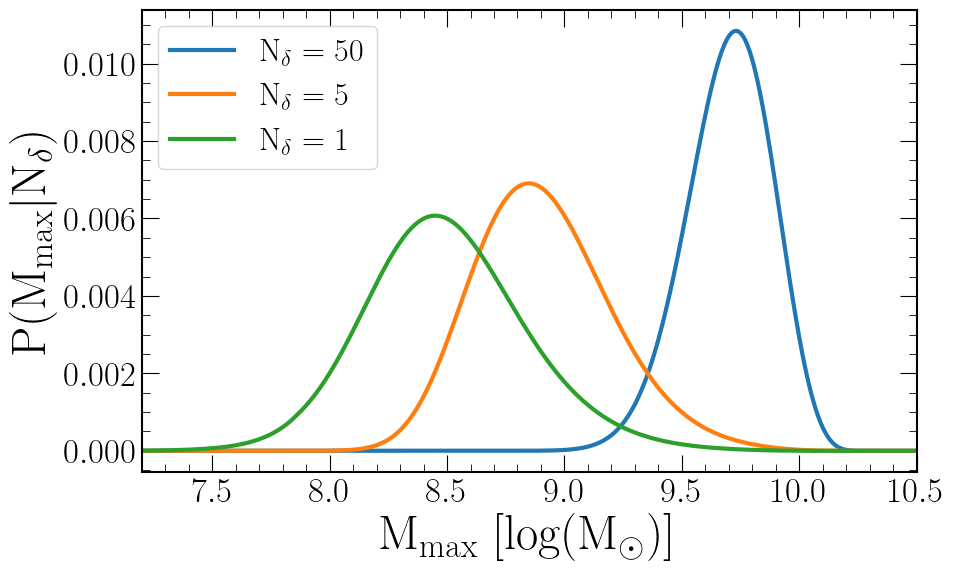

In [ ]:
lw = 3
fig, ax = plt.subplots(figsize = (10,6))
# sigs = [0., -2.2, -4]
# sig_labels = [2, 0, 'Any']
sigs = [-1.2, -3.3, -10]
sig_labels = ['50', '5', '1']
for sigl, sig in zip(sig_labels, sigs):
    with h5py.File(f'../evstats/data/demo_OD_fast_{sig}.h5','r') as hf:
                log10m = hf['log10m'][:]
                z = hf['z'][:]
                evs_OD = hf['evs_OD'][:]
                phi_max_conv = hf['phi_max_conv'][:]
                phi_maxs = hf['phi_maxs'][:]
                smfs = hf['smf'][:]

    ax.plot(log10m[:-1][::2], phi_max_conv[10][::2], lw = lw, label = r'$\mathrm{N_{\delta}}$'+' = '+sigl)
ax.set(xlim = (7.2, 10.5), ylabel = r'$\mathrm{P(M_{max}|\mathrm{N_{\delta}})}$', xlabel = r'$\mathrm{M_{max}~[log(M_{\odot})]}$')
ax.legend()
fig
fig.savefig('paper/demo_NOD.png', dpi = 200, bbox_inches = 'tight')

[5, 92, 173, 335, 497, 659, 821, 902, 980]


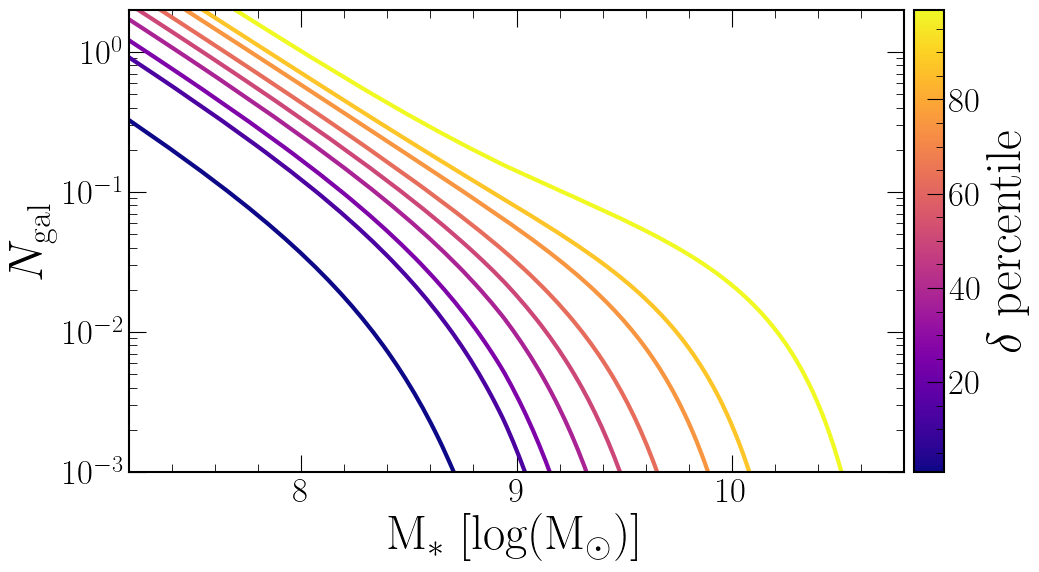

In [162]:
from matplotlib import cm, colors
from scipy.special import erfinv
import scipy as sp
norm = colors.Normalize(1, 99) #sp.stats.norm.isf(2/Ntrials)
fig, ax = plt.subplots(figsize = (10,6))
nsamp = 81
zidx = 0
smf = smfs[zidx]
# idxs = [10, 40, 250]+list(np.arange(len(smfs[10]))[nsamp-10::nsamp])+[9990]
idxs = list(np.arange(len(smf.T))[nsamp-70::nsamp])
idxs = [5, 92, 173, 335, 497, 659, 821, 902, 980]
print(idxs)
lw = 3
f = 1
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, len(idxs)))
k = 0
for c, idx in zip(colors, idxs):
    ax.plot(log10m[:-1], gaussian_filter(smf.T[idx], sigma = 1)*f, \
            c = c, lw = lw, alpha = 1)
    k+=1
ax.set(xlim = (7.2, 10.8), ylim = (1e-3, 2.*f), yscale ='log', ylabel = r'$N_{\mathrm{gal}}$', \
       xlabel = r'$\mathrm{M_{*}~[log(M_{\odot})]}$')

# Add a colorbar without shrinking the main plot
cbar_ax = fig.add_axes([0.91, 0.11, 0.03, 0.77])  # [left, bottom, width, height]
fig.colorbar(cm.ScalarMappable(norm = norm, cmap=cmap), ax = ax, label = r'$\mathrm{\delta~percentile}$', pad = 0.01, cax = cbar_ax)
fig
fig.savefig('paper/overdensity_sampled_percentile.png', dpi = 200, bbox_inches = 'tight')

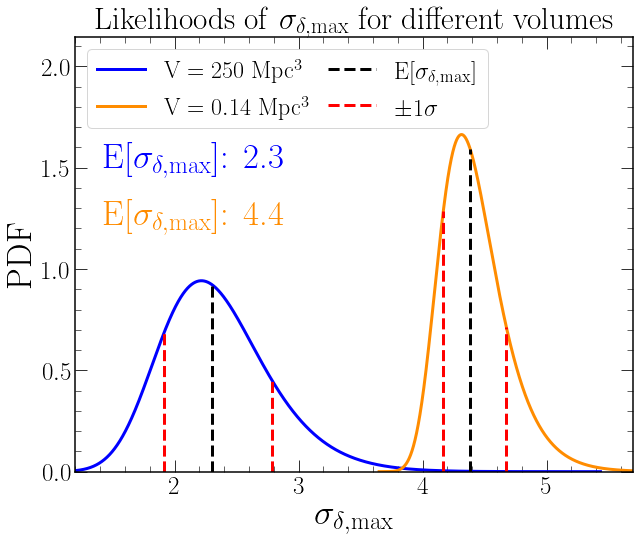

In [211]:
#  N_sky * f_sky * pow(F_sky, N_sky - 1.)

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
csmall = 'darkorange' 

l = 1e-5
fs = 35

N = 65
x = np.linspace(-7, 7, int(1e7))
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
cdf_evs = np.cumsum(evs)/np.sum(evs)
med = x[np.argmin(np.abs(cdf_evs-0.5))]
s1 = x[np.argmin(np.abs(cdf_evs-0.84))]
sm1 = x[np.argmin(np.abs(cdf_evs-0.16))]

ax.plot(x[evs>l], evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=250~Mpc^3}$')
ax.vlines(med, 0, evs[np.argmin(np.abs(cdf_evs-0.50))], c1, linewidth = lwd, linestyle = 'dashed')
ax.vlines(sm1, 0, evs[np.argmin(np.abs(cdf_evs-0.16))], c2, linewidth = lwd, linestyle = 'dashed')
ax.vlines(s1, 0, evs[np.argmin(np.abs(cdf_evs-0.84))], c2, linewidth = lwd, linestyle = 'dashed')

ax.annotate(r'$\mathrm{E[\sigma_{\delta,max}}]$: '+f'{med:.1f}', xy = (0.05,0.7), xycoords = 'axes fraction',\
            color = cbig, fontsize = fs)


N = 119145.0238214981
evs = N*sp.stats.norm.pdf(x)*pow(sp.stats.norm.cdf(x), N - 1.)
cdf_evs = np.cumsum(evs)/np.sum(evs)
med = x[np.argmin(np.abs(cdf_evs-0.5))]
s1 = x[np.argmin(np.abs(cdf_evs-0.84))]
sm1 = x[np.argmin(np.abs(cdf_evs-0.16))]
ax.plot(x[evs>l], evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=0.14~Mpc^3}$')

ax.vlines(med, 0, evs[np.argmin(np.abs(cdf_evs-0.50))], c1, linewidth = lwd, linestyle = 'dashed',\
         label = r'$\mathrm{E[\sigma_{\delta,\mathrm{max}}]}$')
ax.vlines(sm1, 0, evs[np.argmin(np.abs(cdf_evs-0.16))], c2, linewidth = lwd, linestyle = 'dashed',\
         label = r'$\pm 1\sigma$')
ax.vlines(s1, 0, evs[np.argmin(np.abs(cdf_evs-0.84))], c2, linewidth = lwd, linestyle = 'dashed')

ax.set(xlim = (1.2, 5.7), ylim = (0, max(evs)*1.29), xlabel = r'$\sigma_{\delta, \mathrm{max}}$', \
       ylabel = r'$\mathrm{PDF}$', title = r'$\mathrm{Likelihoods~of~\sigma_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.annotate(r'$\mathrm{E[\sigma_{\delta,max}}]$: '+f'{med:.1f}', xy = (0.05,0.57), xycoords = 'axes fraction',\
            color = csmall, fontsize = fs)

ax.legend(ncols = 2, loc = 'upper left', fontsize = 24, columnspacing = 0.8)
fig.savefig('paper/EVS_sigma.png', bbox_inches = 'tight', dpi = 200)

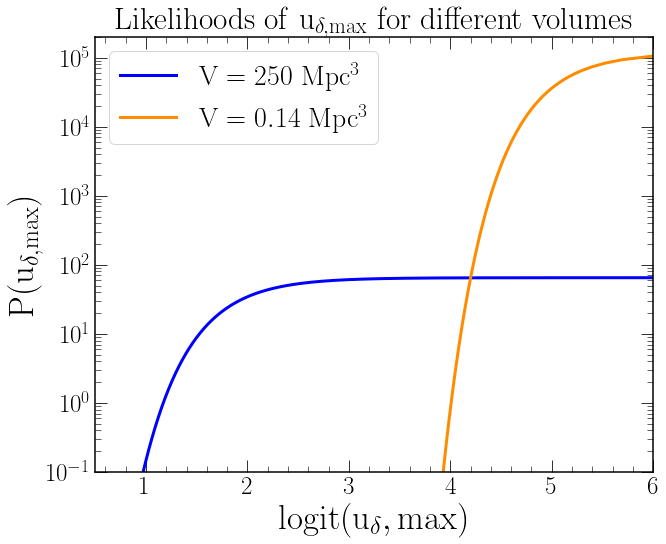

In [213]:
#  N_sky * f_sky * pow(F_sky, N_sky - 1.)
def logit(x):
    return np.log10(x/(1-x))

fig, ax = plt.subplots(figsize = (10, 8))

c1 = 'k'
c2 = 'r'
lwd = 3

cbig = 'b'
csmall = 'darkorange' 

l = 1e-5
fs = 35

N = 65
nsamp = 1e6
x = np.linspace(1/nsamp, 1-1/nsamp, int(nsamp))
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)

ax.plot(logit(x[evs>l]), evs[evs>l], cbig, linewidth = 3, label = r'$\mathrm{V=250~Mpc^3}$')


N = 119145
evs = N*sp.stats.uniform.pdf(x)*pow(sp.stats.uniform.cdf(x), N - 1.)
ax.plot(logit(x[evs>l]), evs[evs>l], csmall, linewidth = 3, label = r'$\mathrm{V=0.14~Mpc^3}$')

ax.set(yscale = 'log', ylim = (1e-1, 2e5), xlim = (0.5, np.log10(nsamp)), xlabel = r'$\mathrm{logit(u_{\delta}, \mathrm{max}})$', \
       ylabel = r'$\mathrm{P(u_{\delta, max})}$', title = r'$\mathrm{Likelihoods~of~u_{\delta,\mathrm{max}}~for~different~volumes}$')

ax.legend(ncols = 1, loc = 'upper left', fontsize = 28, columnspacing = 0.8)
fig.savefig('paper/EVS_percentile.png', bbox_inches = 'tight', dpi = 200)